In [1]:
import torch
import random
import numpy as np

In [2]:
random.seed(5)
np.random.seed(5)
torch.manual_seed(5)
torch.cuda.manual_seed(5)
torch.backends.cudnn.deterministic = True

Скачаем train и test в бибилиотеке torchvision.datasets

In [3]:
import torchvision.datasets
data_train = torchvision.datasets.MNIST('./', download=True, train=True)
data_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [4]:
X_train = data_train.data
y_train = data_train.targets
X_test = data_test.data
y_test = data_test.targets

Посмотрим с какими тапами данных имеем дело:

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

Сами картинки имеют тип uint8, а лейблы int64 Преобразуем данные во float: (нейронные сети, работают лучше с входными данными в формате float)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

Посмотрим на размерности:

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

Видно, что у нас 60к тренировочных и 10к тестовых изображений, размерности 28 на 28 (это очень маленькие картинки поэтому мы можем применить полносвязную НС)

Посмотрим как выгледят эти картинки:

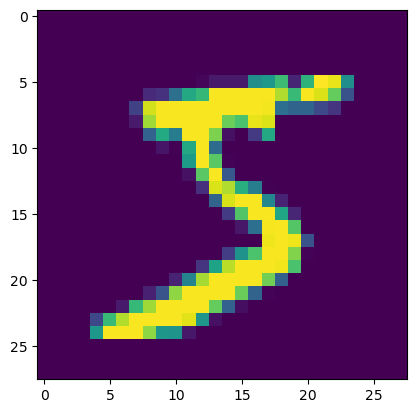

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :]) 
# [0, :, :] выбирает все строки и столбцы для первого измерения 
# (первого изображения) в трехмерном массиве или тензоре
plt.show()
print(y_train[0])

у нас каждая картинка описывается двумерным тензором. Растянем наши картинки в вектор. Для этой задачи подойдет функция reshape.

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

Получим двумерные тензоры. Первая размерность сохранится (для X_train - это 60к, X_test - это 10к), а вторая размерность растянется было 28 на 28, стало 28*28=784

Теперь наши данные можно передавать в полносвязную НС, осталось только её создать)

Создадим НС - MNIST_NS, из трех слоев
Архитектура нейронной сети, сдледующая:
1. Входной слой размерности 784, соответствующей количеству пикселей в исходном изображении MNIST (28x28 пикселей, распределенных в одномерный вектор).
2. Скрытый слой с количеством нейронов, заданным параметром "n_hidden_neurons". Данный слой имеет полносвязную (fully connected) структуру, где каждый нейрон соединен со всеми нейронами предыдущего слоя. Для активации скрытого слоя используется сигмоидная функция активации (Sigmoid).
3. Выходной слой размерности 10, соответствующей количеству классов (цифр от 0 до 9). Выходной слой также имеет полносвязную структуру.

В методе forward() происходит прямое распространение сигнала по нейронной сети. Входные данные подаются на первый слой (fc1), затем применяется функция активации (ac1) для скрытого слоя, и наконец, выход скрытого слоя передается на выходной слой (fc2), где выполняется классификация на 10 классов.

In [11]:
class MNIST_NS(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNIST_NS, self).__init__()
        self.fc1 = torch.nn.Linear(784, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
mnist_ns = MNIST_NS(100) # Данная строка создает объект класса MNIST_NS и 
                         # инициализирует его с параметром n_hidden_neurons равным 100.

Вычисления будут производится на GPU

torch.cuda.is_available() - проверяет доступность и возможность использования GPU с помощью библиотеки PyTorch. Она возвращает логическое значение True, если GPU доступен, и False, если GPU недоступен или не поддерживается.

!nvidia-smi - это магическая команда в среде Jupyter Notebook, которая запускает команду nvidia-smi внутри ячейки кода. Команда nvidia-smi отображает информацию о видеокарте NVIDIA, включая ее использование, память и другие параметры. Это позволяет проверить, что NVIDIA GPU и его драйверы правильно установлены и работают в среде выполнения.

In [12]:
torch.cuda.is_available()
!nvidia-smi

Tue Jun 13 12:52:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P0    13W /  40W |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# Cоздадим объект device, который определяет будет ли использоваться GPU или CPU.
# Если GPU доступен, то будет выбран cuda:0, в противном случае будет использован cpu.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Далее переместим модель mnist_ns на устройство, определенное объектом device.
mnist_ns = mnist_ns.to(device)
# Вернем список параметров модели
list(mnist_ns.parameters())

[Parameter containing:
 tensor([[ 2.3589e-02, -2.6706e-02,  2.9105e-02,  ..., -2.5673e-02,
           4.6108e-03,  1.0614e-03],
         [-3.4149e-02, -3.4945e-02,  2.6578e-03,  ..., -1.7125e-02,
          -1.7524e-02, -2.3914e-02],
         [ 3.2018e-04, -1.5363e-02, -6.2446e-03,  ...,  1.4041e-02,
           1.3359e-02,  5.7493e-03],
         ...,
         [ 7.1479e-03,  3.3594e-02, -2.2407e-02,  ...,  1.4254e-02,
          -3.5439e-02,  1.4134e-02],
         [-9.0551e-03,  1.5361e-03, -1.3621e-02,  ..., -3.3237e-03,
          -1.4011e-02,  1.0047e-05],
         [ 5.3738e-03, -2.2089e-03,  3.2410e-02,  ..., -2.5512e-02,
           2.8580e-02, -2.5849e-02]], requires_grad=True),
 Parameter containing:
 tensor([-0.0090, -0.0039, -0.0349,  0.0056, -0.0040, -0.0321, -0.0230,  0.0205,
          0.0197, -0.0033, -0.0208,  0.0093, -0.0216, -0.0002, -0.0303, -0.0120,
         -0.0233, -0.0223, -0.0273, -0.0209, -0.0158, -0.0162,  0.0235,  0.0022,
          0.0314,  0.0205,  0.0307,  0.0265, 

In [14]:
# Создаем объект функции потерь 
# (воспользуемся CrossEntropyLoss - эта функция потерь часто используется в задачах классификации)
loss = torch.nn.CrossEntropyLoss()
# для обновления параметров модели на основе вычисленных градиентов будем использовать оптимизатор Adam
# скорость обучения возьмем 0.001
optimizer = torch.optim.Adam(mnist_ns.parameters(), lr=1.0e-3)

Теперь напишем процесс обучения

In [15]:
batch_size = 100 # размер бача, то есть количество элементов, 
#которые будут обрабатываться одновременно при обучении модели

test_accuracy_history = [] # в данном списке сохраним значения функции потерь на тестовом наборе данных

# перенесём тестовые данные X_test и лейблы y_test на устройство, указанное в device
X_test = X_test.to(device)
y_test = y_test.to(device)
i = 0
for epoch in range(100):  # Запускаем цикл по эпохам обучения модели
    i +=1
    order = np.random.permutation(len(X_train)) # чтобы модель обучалась на разных частях данных
    # будем перемешивать индексы элементов
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # обнуляем градиенты перед вычислением новых градиентов 
        
        batch_indexes = order[start_index:start_index+batch_size] # выбирает индексы элементов пакета
        
        X_batch = X_train[batch_indexes] 
        y_batch = y_train[batch_indexes] 
        
        preds = mnist_ns.forward(X_batch) # получаем предсказания 
        # вычисляем значение функции потерь между предсказаниями и метками классов:
        loss_value = loss(preds, y_batch) 
        loss_value.backward() #  вычисляем градиенты функции потерь по параметрам модели
        
        optimizer.step() # обновим параметры модели на основе вычисленных градиентов
    # После каждой эпохи ,будем вычислять точность модели на тестовом наборе данных
    test_preds = mnist_ns.forward(X_test)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    # И добавлять значение accuracy в test_accuracy_history
    test_accuracy_history.append(accuracy)
    print(f'{i}) {accuracy}')

1) 0.9125000238418579
2) 0.9164000153541565
3) 0.920799970626831
4) 0.9296000003814697
5) 0.9247000217437744
6) 0.9289000034332275
7) 0.9325000047683716
8) 0.9332000017166138
9) 0.9318000078201294
10) 0.9366000294685364
11) 0.9305999875068665
12) 0.934499979019165
13) 0.9345999956130981
14) 0.9383999705314636
15) 0.9297999739646912
16) 0.9391000270843506
17) 0.9366999864578247
18) 0.9404000043869019
19) 0.9370999932289124
20) 0.9402999877929688
21) 0.9404000043869019
22) 0.9398999810218811
23) 0.9386000037193298
24) 0.942300021648407
25) 0.9391999840736389
26) 0.9409000277519226
27) 0.9431999921798706
28) 0.9456999897956848
29) 0.9412999749183655
30) 0.9452999830245972
31) 0.9480999708175659
32) 0.9462000131607056
33) 0.9466000199317932
34) 0.9478999972343445
35) 0.9460999965667725
36) 0.945900022983551
37) 0.9470999836921692
38) 0.9491999745368958
39) 0.9502000212669373
40) 0.9498000144958496
41) 0.949999988079071
42) 0.9508000016212463
43) 0.9496999979019165
44) 0.9514999985694885
45

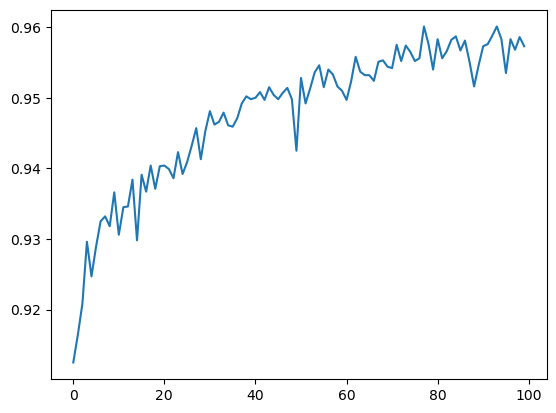

In [16]:
# посмотрим что получилось
plt.plot(test_accuracy_history)

Видно, что accuracy колеблется одноко в целом растет и стремится к кокому-то плато, можно увеличить количество эпох и убедиться, что это так. (Еще можно поиграться с количеством n_hidden_neurons)

Предлагаю создать еще одну НС теперь с другой функцией активации (ReLU) и улеличить количество эпох

In [20]:
# Определение архитектуры нейронной сети
class MNIST_NS_2(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNIST_NS_2, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_ns_2 = MNIST_NS_2(100)

In [21]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_ns_2.parameters(), lr=1.0e-3)

In [22]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
i = 0
for epoch in range(1000): 
    i +=1
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes] 
        y_batch = y_train[batch_indexes] 
        
        preds = mnist_ns_2.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_ns_2.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(f'{i}) {accuracy}')

1) 0.9336000084877014
2) 0.9416000247001648
3) 0.9513000249862671
4) 0.9550999999046326
5) 0.9581999778747559
6) 0.9587000012397766
7) 0.9606999754905701
8) 0.9603999853134155
9) 0.95660001039505
10) 0.9527999758720398
11) 0.9623000025749207
12) 0.9528999924659729
13) 0.9571999907493591
14) 0.9642000198364258
15) 0.9607999920845032
16) 0.9613999724388123
17) 0.9627000093460083
18) 0.9628000259399414
19) 0.9646999835968018
20) 0.9595999717712402
21) 0.9592000246047974
22) 0.9614999890327454
23) 0.9577999711036682
24) 0.9614999890327454
25) 0.9606999754905701
26) 0.9602000117301941
27) 0.9611999988555908
28) 0.9613000154495239
29) 0.9621000289916992
30) 0.9613999724388123
31) 0.9638000130653381
32) 0.9606000185012817
33) 0.9613000154495239
34) 0.9614999890327454
35) 0.9621999859809875
36) 0.9631999731063843
37) 0.9663000106811523
38) 0.9627000093460083
39) 0.9629999995231628
40) 0.9606000185012817
41) 0.9649999737739563
42) 0.9656000137329102
43) 0.9639999866485596
44) 0.9614999890327454

349) 0.9679999947547913
350) 0.9696999788284302
351) 0.9702000021934509
352) 0.9685999751091003
353) 0.9685999751091003
354) 0.9671000242233276
355) 0.9696999788284302
356) 0.9672999978065491
357) 0.9678999781608582
358) 0.9674999713897705
359) 0.9650999903678894
360) 0.9657999873161316
361) 0.9696000218391418
362) 0.9677000045776367
363) 0.9670000076293945
364) 0.9682000279426575
365) 0.9690999984741211
366) 0.9671000242233276
367) 0.9684000015258789
368) 0.9686999917030334
369) 0.9682000279426575
370) 0.9663000106811523
371) 0.9674000144004822
372) 0.9688000082969666
373) 0.9661999940872192
374) 0.9664000272750854
375) 0.968999981880188
376) 0.9689000248908997
377) 0.9700999855995178
378) 0.9682999849319458
379) 0.9679999947547913
380) 0.9685999751091003
381) 0.9704999923706055
382) 0.9682000279426575
383) 0.968999981880188
384) 0.9688000082969666
385) 0.9670000076293945
386) 0.9679999947547913
387) 0.9696999788284302
388) 0.9678999781608582
389) 0.9708999991416931
390) 0.96799999475

692) 0.9681000113487244
693) 0.9686999917030334
694) 0.968999981880188
695) 0.9690999984741211
696) 0.9690999984741211
697) 0.9692999720573425
698) 0.9672999978065491
699) 0.9682000279426575
700) 0.9684000015258789
701) 0.9689000248908997
702) 0.9679999947547913
703) 0.9677000045776367
704) 0.9667999744415283
705) 0.9671000242233276
706) 0.967199981212616
707) 0.9677000045776367
708) 0.9681000113487244
709) 0.968500018119812
710) 0.9682999849319458
711) 0.9664999842643738
712) 0.9677000045776367
713) 0.9666000008583069
714) 0.9682999849319458
715) 0.9682000279426575
716) 0.9686999917030334
717) 0.9674999713897705
718) 0.9674000144004822
719) 0.9682000279426575
720) 0.9672999978065491
721) 0.96670001745224
722) 0.9660999774932861
723) 0.967199981212616
724) 0.9664000272750854
725) 0.9664999842643738
726) 0.9700999855995178
727) 0.9686999917030334
728) 0.9688000082969666
729) 0.9692000150680542
730) 0.9690999984741211
731) 0.9646000266075134
732) 0.9674999713897705
733) 0.966799974441528

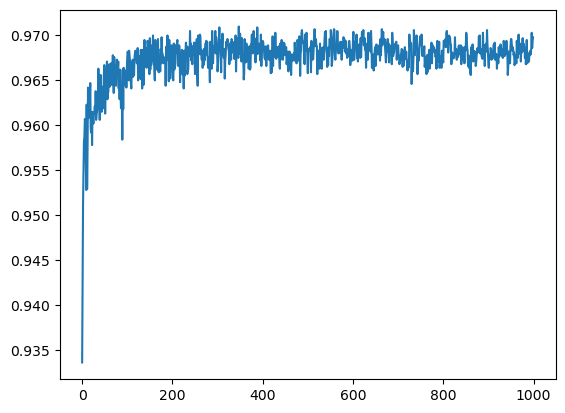

In [23]:
plt.plot(test_accuracy_history)

Видно, что где-то на 300 эпохе вышли на плато, результат около 97%.